<a href="https://colab.research.google.com/github/Jason111-poxie/cloud_classification_project/blob/main/cloud_classification_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
from google.colab import drive
drive.mount('/content/drive')
!pip install rasterio
!pip install matplotlib scikit-learn


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
import rasterio
import numpy as np

# 📁 Path to your exported .tif image
tif_path = '/content/drive/MyDrive/EarthEngineExports/s2_london_2021_cloudy.tif'

# 🔍 Check how many bands and what their names are
with rasterio.open(tif_path) as src:
    print("Band count:", src.count)
    print("Band names:", src.descriptions)  # This may return None if not set

# 📦 Load all bands into a NumPy array
with rasterio.open(tif_path) as src:
    img = src.read()  # shape: (bands, height, width)

# 🧩 Extract the individual bands
b2 = img[0]  # Blue
b3 = img[1]  # Green
b4 = img[2]  # Red
b8 = img[3]  # Near-Infrared
qa60 = img[4]  # Cloud mask from QA60



Band count: 5
Band names: ('B2', 'B3', 'B4', 'B8', 'QA60')


In [83]:
# Simulated label: assume bright pixels are clouds
brightness = (b2 + b3 + b4) / 3
labels = (brightness.flatten() > 3000).astype(int)

# Features (same as before)
flat_b2 = b2.flatten()
flat_b3 = b3.flatten()
flat_b4 = b4.flatten()
flat_b8 = b8.flatten()
features = np.stack([flat_b2, flat_b3, flat_b4, flat_b8], axis=1)

# Filter nodata
valid = np.sum(features, axis=1) > 0
features = features[valid]
labels = labels[valid]

# Check distribution
unique, counts = np.unique(labels, return_counts=True)
print("Label distribution (manual brightness mask):", dict(zip(unique, counts)))




Label distribution (manual brightness mask): {np.int64(0): np.int64(89027), np.int64(1): np.int64(84028)}


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17897
           1       1.00      1.00      1.00     16714

    accuracy                           1.00     34611
   macro avg       1.00      1.00      1.00     34611
weighted avg       1.00      1.00      1.00     34611



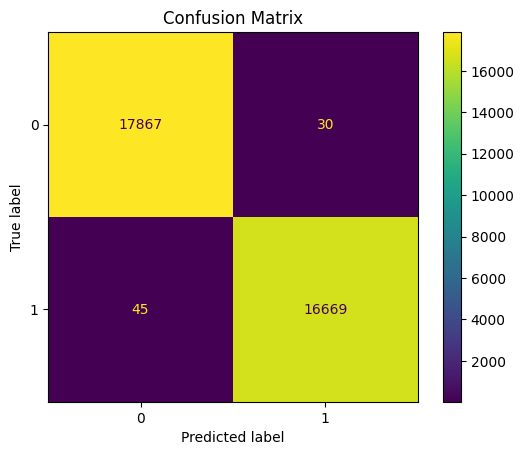

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.show()


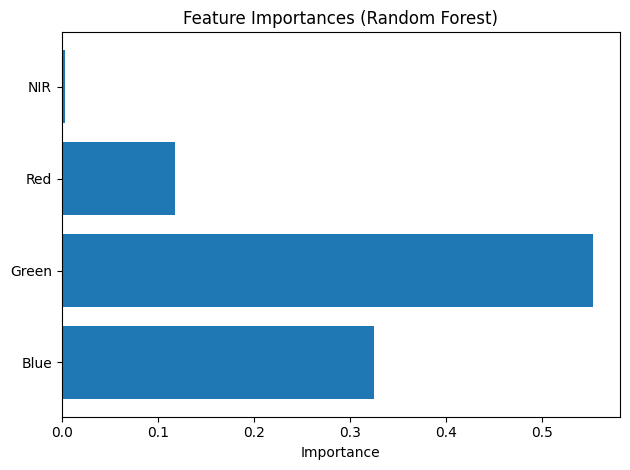

In [85]:
# 🎯 Feature Importance Visualization
importances = clf.feature_importances_
feature_names = ['Blue', 'Green', 'Red', 'NIR']
plt.barh(feature_names, importances)
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

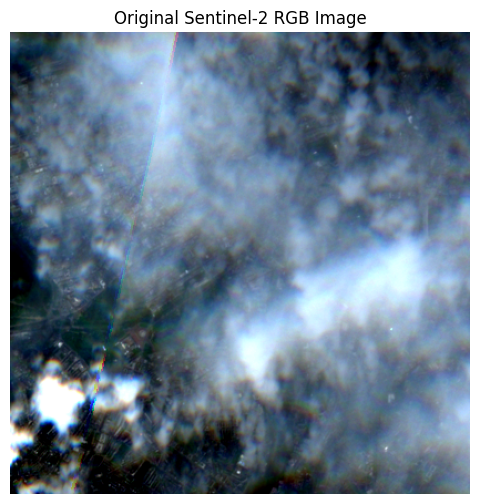

In [86]:
# Normalize reflectance to 0–1 (Sentinel-2 SR is scaled by 10000)
rgb = np.stack([b4, b3, b2], axis=-1).astype(np.float32)
rgb = rgb / 10000.0

# Percentile stretch (optional for better contrast)
p2 = np.percentile(rgb, 2)
p98 = np.percentile(rgb, 98)
rgb = np.clip((rgb - p2) / (p98 - p2), 0, 1)

# Show the RGB image
plt.figure(figsize=(10, 6))
plt.imshow(rgb)
plt.title("Original Sentinel-2 RGB Image")
plt.axis('off')
plt.show()


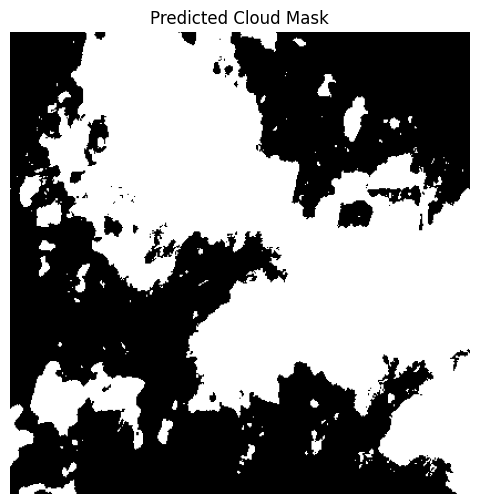

In [87]:
# Predict entire image
pred_all = clf.predict(np.stack([b2, b3, b4, b8], axis=-1).reshape(-1, 4))

# Reconstruct cloud mask image
pred_mask = np.zeros_like(qa.flatten())
pred_mask[valid] = pred_all
pred_mask = pred_mask.reshape(qa.shape)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Cloud Mask")
plt.axis('off')
plt.show()
